In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, average_precision_score, 
                             roc_auc_score, classification_report, precision_score,
                             recall_score, make_scorer)

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from collections import Counter
import joblib
import ast
import geopy
import warnings 
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('~/2021-homework2-multiclass-classification/train.csv', parse_dates=['created'], sep=';')
test = pd.read_csv('~/2021-homework2-multiclass-classification/test.csv', parse_dates=['created'], sep=';')

In [130]:
'train: ', train.shape, 'test: ', test.shape

('train: ', (39450, 23), 'test: ', (9871, 14))

Результат нужно сохранить в **csv файл с двумя колонками**: 

listing_id - берете из датасета

interest_level - проставляете своим алгоритмом

Разделитель **запятая**, при сохранении с помощью result.to_csv() - не забывайте указывать index=None.

In [131]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9871 entries, 0 to 9870
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bathrooms        9871 non-null   float64       
 1   bedrooms         9871 non-null   int64         
 2   building_id      9871 non-null   object        
 3   created          9871 non-null   datetime64[ns]
 4   description      9569 non-null   object        
 5   display_address  9841 non-null   object        
 6   features         9871 non-null   object        
 7   latitude         9871 non-null   float64       
 8   listing_id       9871 non-null   int64         
 9   longitude        9871 non-null   float64       
 10  manager_id       9871 non-null   object        
 11  photos           9871 non-null   object        
 12  price            9871 non-null   int64         
 13  street_address   9870 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(

## Анализ данных
### 1. Предобработка и генерация признаков

Ниже представлены имеющиеся у нас признаки. Можно попробовать сгенерировать из них новые. Например, можно сделать признак Стоимость за комнату, признаки на основе значений в features, выделить и закодировать адрес, так же можно попробовать оценить "успешность" менеджера, предположив, что чем больше объявлений у данного manager_id - тем он круче.

In [55]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level',
       'features_cnt', 'photos_cnt'],
      dtype='object')

In [4]:
train['features']

0                         ['Cats Allowed', 'Dogs Allowed']
1                                                       []
2              ['Doorman', 'Dogs Allowed', 'Cats Allowed']
3        ['Swimming Pool', 'Roof Deck', 'Dining Room', ...
4                  ['Doorman', 'Fitness Center', 'No Fee']
                               ...                        
39476                     ['Dogs Allowed', 'Cats Allowed']
39477    ['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...
39478                       ['Elevator', 'Fitness Center']
39479    ['Pre-War', 'Laundry in Unit', 'Dishwasher', '...
39480    ['Doorman', 'Fitness Center', 'Elevator', 'Sto...
Name: features, Length: 39481, dtype: object

Строки превращаем обратно в список

In [6]:
features_train = train['features'].apply(ast.literal_eval).apply(lambda x: [*map(str.lower, x)])
features_test = test['features'].apply(ast.literal_eval).apply(lambda x: [*map(str.lower, x)])

In [25]:
features_names = np.concatenate(np.r_[features_train, features_test])

Отбираем 30 самых встречающихся тега и будем использовать их как дополнительный ряд признаков.

In [190]:
top_features

['elevator',
 'hardwood floors',
 'cats allowed',
 'dogs allowed',
 'doorman',
 'dishwasher',
 'laundry in building',
 'no fee',
 'fitness center',
 'laundry in unit',
 'pre-war',
 'roof deck',
 'outdoor space',
 'dining room',
 'high speed internet',
 'balcony',
 'swimming pool',
 'new construction',
 'terrace',
 'exclusive',
 'loft',
 'garden/patio',
 'wheelchair access',
 'prewar',
 'common outdoor space',
 'hardwood',
 'fireplace',
 'simplex',
 'lowrise',
 'garage']

In [29]:
top_features = Counter(features_names).most_common(30)
top_features = [x[0] for x in top_features]

In [30]:
def featurer(df, features):
    vec = np.zeros(len(top_features))
    for i, feature in enumerate(features):
        vec[i] = feature in df
    return vec

Создаем датафрейм, где столбцы — это признаки-теги, строки — вектора, указывающие на содержание определенного тега в объявлении.

In [188]:
features_train_df = pd.DataFrame(features_train.apply(featurer,
                            features=top_features).to_list(),
                            columns=['_'.join(x.split()) for x in top_features])
features_train_df.head()

,elevator,hardwood_floors,cats_allowed,dogs_allowed,doorman,dishwasher,laundry_in_building,no_fee,fitness_center,laundry_in_unit,...,loft,garden/patio,wheelchair_access,prewar,common_outdoor_space,hardwood,fireplace,simplex,lowrise,garage
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


То же самое для тестовой выборки.

In [34]:
features_test_df = pd.DataFrame(features_test.apply(featurer,
                            features=top_features).to_list(),
                            columns=['_'.join(x.split()) for x in top_features])

Количество фичей для каждого объявления.

In [132]:
train['features_cnt'] = train['features'].apply(ast.literal_eval).apply(len)
test['features_cnt'] = test['features'].apply(ast.literal_eval).apply(len)

Количество фотографий. При желании можно учитывать и размер фото.

In [133]:
train['photos_cnt'] = train['photos'].apply(ast.literal_eval).apply(len)
test['photos_cnt'] = test['photos'].apply(ast.literal_eval).apply(len)

In [37]:
target = 'interest_level' # определяем целевую переменную

Наработка для получения zip-кода по координатам. *Слишком затратно по времени.*

In [57]:
# def get_zipcode(df, geolocator, lat_field, lon_field):
#    location = geolocator.reverse((df[lat_field], df[lon_field]))
#    return location.raw['address'].get('postcode', np.nan)


# geolocator = geopy.Nominatim(user_agent='application')
# train_zips = train.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

Выделяем день недели и час публикации.

In [134]:
train["weekday"] = train["created"].dt.weekday
test["weekday"] = test["created"].dt.weekday

In [135]:
train["hour"] = train["created"].dt.hour
test["hour"] = test["created"].dt.hour

Считаем относительную стоимость комнаты.

In [136]:
train["room_cost"] = train.price / (train.bedrooms + 1)
test["room_cost"] = test.price / (test.bedrooms + 1)

Отношение количества ванных комнат к спальням.

In [137]:
train["bath_bad_rate"] = train.bathrooms / (train.bedrooms + 1)
test["bath_bad_rate"] = test.bathrooms / (test.bedrooms + 1)

Время жизни объявления относительно самого свежего.

In [138]:
train["days_exposition"] = (train.created - train.created.max()).dt.days.abs()
test["days_exposition"] = (test.created - test.created.max()).dt.days.abs()

Количество слов в описании. Можно считать посимвольно.

In [139]:
train["description_words"] = train.description.fillna('').str.split().apply(len)
test["description_words"] = test.description.fillna('').str.split().apply(len)

Визуализируем распеделение количества спален.

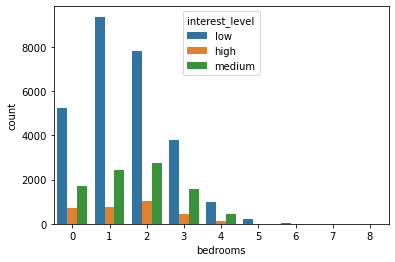

In [68]:
sns.countplot(x='bedrooms', hue='interest_level', data=train);

Для разных типов объявлений распределение приблизительно одинаково.

#### Анализируем выбросы

Есть квартиры значительно дороже остальных. Граница — 1 млн. долл. сша.

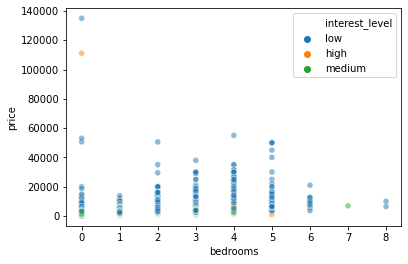

In [199]:
sns.scatterplot(x='bedrooms', y='price', data=train, hue='interest_level', alpha=.5);

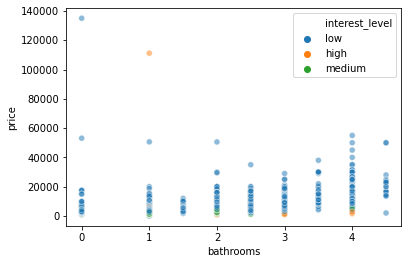

In [200]:
sns.scatterplot(x='bathrooms', y='price', data=train, hue='interest_level', alpha=.5);

Избавляемся от выбросов.

In [140]:
train = train.query('bathrooms < 5 & price < 1e6')

## 2. Тестирование различных алгоритмов

Для выполнения этой части задания разбейте размеченные данные на train и test и напишите автоматическое тестирование разных алгоритмов классификации в цикле с вычислением метрики `f1_score('macro')`.

In [80]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=3),
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
    'RandomForestClassifier': RandomForestClassifier(),
    'MLPClassifier': MLPClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'CatBoostClassifier': CatBoostClassifier(loss_function='MultiClass',
                                             logging_level='Silent'),
    'LGBMClassifier': LGBMClassifier(boosting_type="gbdt",
                                     objective="multiclass",
                                     learning_rate=0.05),
    'XGBClassifier': XGBClassifier()
}

Выбираем признаки, которые будут участвовать в моделировании.

In [47]:
to_drop = ['building_id', 'created', 'description', 
           'display_address', 'features', 'listing_id', 
           'manager_id', 'photos', 'street_address']

to_use = [x for x in train.columns if x not in to_drop + [target]]
to_use

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'price',
 'features_cnt',
 'photos_cnt',
 'weekday',
 'hour',
 'room_cost',
 'bath_bad_rate',
 'days_exposition',
 'description_words']

Шкалируем вещественные признаки.

In [121]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[to_use])

In [122]:
scaled = train.copy()

In [124]:
scaled[to_use] = scaled_train
scaled = scaled[to_use].join(features_train_df)

Разбиваем выборку на тренировочную и валидационную в соотношении 1/3

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train[to_use].join(features_train_df),
                                                    train[target].map(mapper),
                                                    test_size=0.3)

In [50]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27615, 43), (11835, 43), (27615,), (11835,))

In [48]:
mapper = {
        'low':0,
        'medium':1,
        'high':2
       }

Прогоняем данные по пулу моделей, ориентируясь на значение `f1_score`.

In [81]:
for name, model in classifiers.items():
    print(name)
    model_ = model
    model_.fit(X_train, y_train)
    predicts = model_.predict(X_test)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    print('На отложенной тестовой выборке: ')
    print('%s: F_мера: %7.5f, average precision score: %7.5f, ' % (name, f1, average_precision_score))
    print('-'*30)

KNeighborsClassifier
На отложенной тестовой выборке: 
KNeighborsClassifier: F_мера: 0.42310, average precision score: 0.46199, 
------------------------------
DecisionTreeClassifier
На отложенной тестовой выборке: 
DecisionTreeClassifier: F_мера: 0.48691, average precision score: 0.48765, 
------------------------------
RandomForestClassifier
На отложенной тестовой выборке: 
RandomForestClassifier: F_мера: 0.51377, average precision score: 0.60968, 
------------------------------
MLPClassifier
На отложенной тестовой выборке: 
MLPClassifier: F_мера: 0.27251, average precision score: 0.62355, 
------------------------------
AdaBoostClassifier
На отложенной тестовой выборке: 
AdaBoostClassifier: F_мера: 0.48062, average precision score: 0.58111, 
------------------------------
CatBoostClassifier
На отложенной тестовой выборке: 
CatBoostClassifier: F_мера: 0.54872, average precision score: 0.61908, 
------------------------------
LGBMClassifier
На отложенной тестовой выборке: 
LGBMClassifi

Лучшее значение показал бустинговый классификатор XGBClassifier.

## 3. Отбор признаков

[Отбор признаков](https://scikit-learn.org/stable/modules/feature_selection.html)

Для отбора признаков выберем ExtraTreesClassifier и «важность» признаков xgboost.

In [82]:
clf = ExtraTreesClassifier(n_estimators=100)

In [83]:
clf = clf.fit(X_train, y_train)

In [84]:
model = SelectFromModel(clf, prefit=True)
X_train_ext = model.transform(X_train)

In [85]:
X_test_ext = model.transform(X_test)

In [86]:
X_test_ext.shape

(11835, 12)

Признаковое пространство сократилось почти в два раза.

In [87]:
for name, model in classifiers.items():
    print(name)
    model_ = model
    model_.fit(X_train_ext, y_train)
    predicts = model_.predict(X_test_ext)
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    print('На отложенной тестовой выборке: ')
    print('%s: F_мера: %7.5f, average precision score: %7.5f, ' % (name, f1, average_precision_score))
    print('-'*30)

KNeighborsClassifier
На отложенной тестовой выборке: 
KNeighborsClassifier: F_мера: 0.42272, average precision score: 0.46193, 
------------------------------
DecisionTreeClassifier
На отложенной тестовой выборке: 
DecisionTreeClassifier: F_мера: 0.47635, average precision score: 0.47592, 
------------------------------
RandomForestClassifier
На отложенной тестовой выборке: 
RandomForestClassifier: F_мера: 0.50910, average precision score: 0.59158, 
------------------------------
MLPClassifier
На отложенной тестовой выборке: 
MLPClassifier: F_мера: 0.13489, average precision score: 0.39985, 
------------------------------
AdaBoostClassifier
На отложенной тестовой выборке: 
AdaBoostClassifier: F_мера: 0.46375, average precision score: 0.56764, 
------------------------------
CatBoostClassifier
На отложенной тестовой выборке: 
CatBoostClassifier: F_мера: 0.53208, average precision score: 0.60988, 
------------------------------
LGBMClassifier
На отложенной тестовой выборке: 
LGBMClassifi

Но это только ухудшило показатели.

Определим важность признаков в модели xgboost и отрисуем их.

In [90]:
import xgboost as xgb
clf = xgb.train({'objective':'multi:softprob', 'num_class':3, 'eval_metric': 'mlogloss'},
                 xgb.DMatrix(X_train.values, y_train, feature_names=list(X_train.columns)), 
                             num_boost_round=100, maximize=True)

In [89]:
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10,10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='b')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [91]:
importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-15:])

15 самых важных признаков, определенных моделью XGBoost.

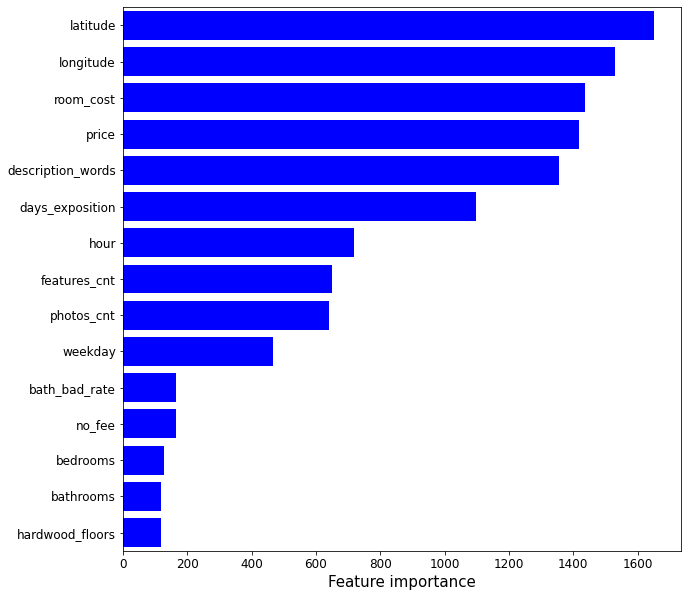

In [92]:
draw_feature_importances(clf, 15)

In [94]:
for name, model in classifiers.items():
    print(name)
    model_ = model
    model_.fit(X_train[importances.keys()], y_train)
    predicts = model_.predict(X_test[importances.keys()])
    f1 = f1_score(y_test, predicts, average='macro')
    average_precision_score = precision_score(y_test, predicts, average='macro')
    print('На отложенной тестовой выборке: ')
    print('%s: F_мера: %7.5f, average precision score: %7.5f, ' % (name, f1, average_precision_score))
    print('-' * 30)

KNeighborsClassifier
На отложенной тестовой выборке: 
KNeighborsClassifier: F_мера: 0.42358, average precision score: 0.46329, 
------------------------------
DecisionTreeClassifier
На отложенной тестовой выборке: 
DecisionTreeClassifier: F_мера: 0.48397, average precision score: 0.48567, 
------------------------------
RandomForestClassifier
На отложенной тестовой выборке: 
RandomForestClassifier: F_мера: 0.51938, average precision score: 0.60454, 
------------------------------
MLPClassifier
На отложенной тестовой выборке: 
MLPClassifier: F_мера: 0.41674, average precision score: 0.55130, 
------------------------------
AdaBoostClassifier
На отложенной тестовой выборке: 
AdaBoostClassifier: F_мера: 0.47804, average precision score: 0.56702, 
------------------------------
CatBoostClassifier
На отложенной тестовой выборке: 
CatBoostClassifier: F_мера: 0.54406, average precision score: 0.60922, 
------------------------------
LGBMClassifier
На отложенной тестовой выборке: 
LGBMClassifi

Работая с этими признаками модели показали результат незначительно лучше, по сравнению с базовым набором.

## 4. Подбор гиперпараметров

Для этого задания подберите гиперпараметры как минимум для 3 алгоритмов из протестированных выше. Используйте Grid Search или Random Search, в качестве метрики передавайте `f1_score`.

Для `RandomForestClassifier` используем `RandomizedSearchCV`.

In [95]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
params = {
    'max_depth': [3, 4, None, 5, 6],
    "min_samples_leaf": list(range(1, 5))
}

rf = RandomForestClassifier(n_estimators=100, oob_score=True)

dt_random_search = RandomizedSearchCV(rf, params, cv=skf, verbose=1)
dt_random_search.fit(X_train, y_train)

print(dt_random_search.best_estimator_)
print(dt_random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


RandomForestClassifier(oob_score=True, random_state=42)
{'min_samples_leaf': 1, 'max_depth': None}


Лучшими параметрами стали
```python
{'min_samples_leaf': 1, 'max_depth': None}```

Для двух бустинговых моделей будем использовать `GridSearchCV`

In [97]:
def get_best_model(model, params, x_train, x_test, y_train, y_test,
                   score=make_scorer(f1_score, average='macro')):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    best_model.fit(x_train, y_train)
    predicted = best_model.predict(x_test)

    metrics = {metric: f(y_test, predicted, average='macro') 
                        for metric, f in zip(['precision', 'f1'], [precision_score, f1_score])}
    print('Лучшие параметры модели:', grid.best_params_, end='\n')
    report = pd.DataFrame(metrics.values(), index=metrics.keys(), columns=['Значения метрик'])
    return best_model, report

In [455]:
param_xgb = {
    "n_estimators": range(1, 151, 10),
    "max_depth": list(range(2, 11, 1)) + [None],
#    "subsample": np.arange(0.6, 1.0, 0.1),
#    "colsample_bytree":  np.arange(0.6, 1.0, 0.1),
#    "eta": np.arange(0.1, 1, 0.1),
}
xgb_model, df_xgb = get_best_model(
    XGBClassifier(learning_rate=0.05, nrounds=100, eta=0.1,
                  objective='multi:softprob', num_class=3, eval_metric='mlogloss'),
    param_xgb,
    X_train,
    X_test,
    y_train,    
    y_test
)

Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 49}


In [458]:
df_xgb

,Значения метрик
precision,0.600412
f1,0.509178


In [98]:
%%time
param_ctb = {
    "depth": range(2, 16, 2),
}
ctb_model, df_ctb = get_best_model(
    CatBoostClassifier(iterations=50, learning_rate=0.1, logging_level='Silent'),
    param_ctb,
    X_train,
    X_test,
    y_train,    
    y_test
)
df_ctb

Лучшие параметры модели: {'depth': 10}
CPU times: user 35min 9s, sys: 19min 30s, total: 54min 39s
Wall time: 37min 29s


,Значения метрик
precision,0.600481
f1,0.455998


## 5. Стэкинг алгоритмов

Для выполнения этой части задания реализуйте стэкинг нечетного числа алгоритмов (больше одного конечно).

[Voting classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

[Stacked-generalization](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)

Попробуем стек из 3-х моделей:
 1. RandomForestClassifier
 2. LinearSVC
 3. LogisticRegression

In [116]:
estimators = [('rf', RandomForestClassifier(n_estimators=10)),
              ('svr', make_pipeline(StandardScaler(),
                                    LinearSVC()))]
clf = StackingClassifier(estimators=estimators,
                         final_estimator=LogisticRegression())

In [117]:
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())

In [119]:
predicts = clf.predict(X_test)
f1_score(y_test, predicts, average='macro')

0.49246720552921497

Значения стека оказались чуть хуже отдельных бустинговых моделей.

## 6. Добавление номера кластера в качестве признака

Сделать кластеризацию данных хотя бы на числовых признаках, кластер добавить к данным в качестве признака и обучить на этом классификатор.

Сравнить метрику с кластером-признаком и без.

При использовании `k-means` нужно сделать подбор количества кластеров одним из способов The Elbow Method или The Silhouette Method. [Как же это сделать в питоне](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

In [126]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k).fit(scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled, labels, metric='euclidean'))

График метода The Silhouette Method

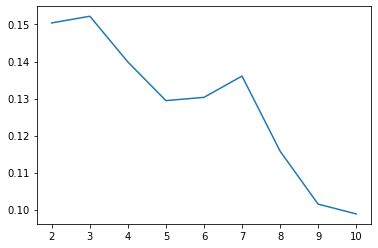

In [168]:
sns.lineplot(range(2, kmax+1), sil);

Оптимальное количество кластеров – 3.

In [169]:
k = 3
kmeans = KMeans(n_clusters=k).fit(scaled)

In [172]:
train['cluster'] = kmeans.labels_

In [173]:
scaled_test = scaler.fit_transform(test[to_use])

In [174]:
kmeans = KMeans(n_clusters=k).fit(scaled_test)
test['cluster'] = kmeans.labels_

In [182]:
to_use.append('cluster')
X_train, X_test, y_train, y_test = train_test_split(train[to_use].join(features_train_df), train_target,
                                                                    test_size=0.3, stratify=train_target)

Тестируем данные с новым признаком на двух бустинговых моделях.

In [183]:
xgb_ = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss')
xgb_.fit(X_train, y_train)
predicts = xgb_.predict(X_test)

In [184]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

        high       0.54      0.27      0.36       928
         low       0.80      0.92      0.86      8225
      medium       0.49      0.34      0.40      2682

    accuracy                           0.74     11835
   macro avg       0.61      0.51      0.54     11835
weighted avg       0.71      0.74      0.71     11835



In [185]:
ctb_ = classifiers['CatBoostClassifier']
ctb_.fit(X_train, y_train)
predicts = ctb_.predict(X_test)

In [186]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

        high       0.54      0.27      0.36       928
         low       0.80      0.93      0.86      8225
      medium       0.48      0.32      0.39      2682

    accuracy                           0.74     11835
   macro avg       0.61      0.51      0.54     11835
weighted avg       0.71      0.74      0.71     11835



Добавление нового признака не показало роста качества аппроксимации данных нашими моделями.

## 7. Итоговое решение и сабмит

Лучшую модель XGBoost используем для классификации тестовых данных.

In [147]:
train = train.set_index('listing_id')
train_target = train[target]

In [156]:
test[target] = xgb_.predict(test[to_use].join(features_test_df))

In [157]:
test[target] = test[target].map(mapper)

In [159]:
test[['listing_id', target]].to_csv('xgb_predictions.csv', index=None)